In [54]:
import matplotlib.pyplot as plt
import numpy as np

from utility import *

from scipy.fft import fft, ifft, fftfreq, fftshift
import scipy.signal

from tensorforce.environments import Environment
from tensorforce.agents import Agent

# Radar Environment Setup

In [55]:
# implement the radar environment
class RadarEnvironment(Environment):
    def __init__(self, basis_freqs):
        """[summary]

        Args:
            basis_freqs ([type] Nx1 numpy array): [description] contains N basis angular freqs
            max_timesteps ([type] int ): [description] the maximum number of timesteps per episode
        """

        # define environment hyperparameters (in this case, the hyperparameters are the radar waveform set parameterization)
        self.basis_freqs = basis_freqs
        self.N = self.basis_freqs.size
        self.band_width = np.max(self.basis_freqs) - np.min(self.basis_freqs)
        self.Fs = 2 * self.band_width  # sampling frequency for the radar waveform
        # duration is two periods of the exponential with the smallest freq
        self.duration = (0, 2 * 1.0 / np.min(np.abs(self.basis_freqs)))

        super().__init__()

    def states(self):
        return dict(type='float', shape=(self.N, 1), min_value=-1.0, max_value=1.0)

    # Q: does action have to be discrete??
    def actions(self):
        # 0: -0.1, 1: 0, 2: 0.1
        return dict(type='int', shape=(self.N, 1), num_actions=3)

    def action_map(self, actions):
        """[summary] 0: -0.1, 1: 0, 2: 0.1
            e.g. 

            actions repr used by agent: [0 1 2 1 1].T --> actions repr used by the environment [-0.1 0 0.1 0 0].T

        Args:
            actions ([type]): [description] the actions repr used by the agent

        Returns:
            [type]: [description] the actions repr used by the environment
        """
        return -0.1 + 0.1 * actions

    def max_episode_timesteps(self):
        return super().max_episode_timesteps()

    def close(self):
        super().close()

    def reset(self):
        self.timestep = 0
        self.current_state = np.random.uniform(
            low=-1.0, high=1.0, size=(self.N, 1))

        return self.current_state


    #####################################################################
    # Utility functions for computing waveform parameters
    #####################################################################

    @staticmethod
    def freqD_to_timeD(state, duration, basis_freqs, Fs):
        """[summary]

        Args:
            state ([type]): [description] a column vector (2D np array with shape (N, 1))
            duration ([type] a tuple (start_time, end_time)): [description]
            basis_freqs ([type] column vector): [description]
            BW ([type] scalar): [description]
            Fs ([type] scalar): [description]

        Returns:
            [type]: [description] p_b is a row vector, a row vector is a 2-D np array with shape(1, N)
        """

        w = 2*np.pi*basis_freqs

        a = state.T
        t = np.arange(duration[0], duration[1], 1.0/Fs).reshape((1, -1))

        A = w @ t

        p_b = a @ np.exp(1j * A) # here p_b is a row vector

        return p_b

    @staticmethod
    def point_spread_fn(p_b, Fs):
        """[summary] assume p_b is a row vector

        Args:
            p_b ([type]): [description] a row vector
            Fs ([type]): [description] sampling frequency

        Returns:
            [type]: [description] (t, psf): all row vectors
        """
        (freqs, spectrum) = fourier_spectrum(p_b, Fs)
        psd = np.abs(spectrum) ** 2
        psf = fftshift(ifft(psd))

        N = psf.size
        t = np.linspace(0, N * 1.0 / Fs, N).reshape((1, -1))
        return t, psf

    @staticmethod
    def peak_sidelobe_level(psf):
        """[summary]

        Args:
            psf ([type] row vector): [description] row vector with shape (1, N)

        Returns:
            [type]: [description] peak sidelobe level, which is a negative real number
        """       
        psf_abs = np.abs(psf) 
        psf_abs_sorted = np.sort(psf_abs)

        PSL = 20 * np.log10(psf_abs_sorted[0, -2] / psf_abs_sorted[0, -1])
        return PSL

    @staticmethod
    def main_lobe_width(state):
        pass

    ################################################################
    # methods that defines the environment dynamics
    ###################################################################

    # define helper functions used by execute()
    def state_transition(self, actions):
        """[summary]

        Args:
            actions ([type]): [description] At, action repr used by the agent

        Returns:
            [type]: [description] S_(t+1), the next_state of the environment
        """
        actions = self.action_map(
            actions)  # convert action repr used by agent to action repr used by envrionment
        next_state = self.current_state + actions

        return next_state

    
    def compute_reward(self, state):
        """[summary] Compute the reward associated with the inpute state

        Args:
            state ([type]): [description]
        """
        p_b = RadarEnvironment.freqD_to_timeD(state, self.duration, self.basis_freqs, self.Fs)
        (t, psf) = RadarEnvironment.point_spread_fn(p_b, Fs)
        PSL = RadarEnvironment.peak_sidelobe_level(psf) # recall it is always a negative scalar
        
        reward = -PSL
        return reward


    def dynamics_fn(self, actions):
        """The dynamics_fn is a blackbox whose input is current_state and action, 
        and output is (next_state, reward).

        In this implementation, the current_state is contained in "self", thus, we don't 
        explicitly inlude current_state as input.

        Args:
            actions ([type] N by 1 integer arrays): [description] action repr used by the agent

        Returns:
            (next_state, reward)
        """

        # define helper functions for computing reward: recall the reward R_(t+1) is due to A_t and S_t,
        # thus R_(t + 1) is associated with the reward for state S_(t + 1)

        pass

    def execute(self, actions):

        # increment timestep
        self.timestep += 1

        # update the current_state
        self.current_state, self.reward = self.dynamics_fn(actions)

        terminal = False

        return self.current_state, terminal, self.reward


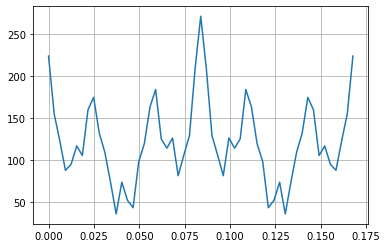

In [56]:
# test static functions
a = np.array([[0.69510533,  0.71412636,  0.875926, -0.36179501,  0.82492313,
               0.59798141, -0.30389625,  0.44194973, -0.62593526, -0.21701164]])
state = a.T
basis_freqs_10 = np.array([[-24],
                           [46],
                           [-36],
                           [25],
                           [-25],
                           [13],
                           [32],
                           [12],
                           [94],
                           [-70]])

duration = (0, 2 * 1.0 / np.min( np.abs(basis_freqs_10[basis_freqs_10 != 0]) ))

BW = np.max(basis_freqs_10) - np.min(basis_freqs_10)

Fs = 2*BW

p_b = RadarEnvironment.freqD_to_timeD(state, duration,basis_freqs_10, Fs)

t, psf = RadarEnvironment.point_spread_fn(p_b, Fs)


plt.plot(t[0], np.abs(psf[0]))
plt.grid()
plt.show()


In [57]:
PSL = RadarEnvironment.peak_sidelobe_level(psf)
PSL

-1.6639485783393428

In [58]:
np.sort(np.abs(psf))

array([[ 36.42622729,  36.42622729,  43.79219786,  43.79219786,
         52.64178015,  52.64178015,  73.91007363,  73.91007363,
         74.0703883 ,  74.0703883 ,  81.73322842,  81.73322842,
         88.14122803,  88.14122803,  95.25975009,  95.25975009,
         98.30813417,  98.30813417, 105.72288638, 105.72288638,
        106.12327914, 106.12327914, 109.16701585, 109.16701585,
        114.37102737, 114.37102737, 116.98950225, 116.98950225,
        119.84131221, 119.84131221, 122.91352208, 122.91352208,
        125.26742949, 125.26742949, 126.44480409, 126.44480409,
        129.16725917, 129.16725917, 132.24201065, 132.24201065,
        155.06530928, 155.06530928, 159.90087252, 159.90087252,
        163.21809691, 163.21809691, 174.63563508, 174.63563508,
        183.89285442, 183.89285442, 208.41940765, 208.41940765,
        223.5758303 , 223.5758303 , 270.78355226]])

In [59]:
20*np.log10(223.57/270.78)

-1.6640611417811557

In [7]:
# test area
N = 10
max_timesteps = 100
basis_freqs_10 = np.random.uniform(low=-100, high=100, size=(N, 1))
radar_env = Environment.create(environment=RadarEnvironment,
                               max_episode_timesteps=max_timesteps, basis_freqs=basis_freqs_10)


# Agent Setup

In [3]:
# check the tensorforce agent specs: https://tensorforce.readthedocs.io/en/latest/agents/tensorforce.html
# it includes the discount factor

agent = Agent.create(
    agent='tensorforce', environment=radar_env, update=64,
    optimizer=dict(optimizer='adam', learning_rate=1e-3),
    objective='policy_gradient', reward_estimation=dict(horizon=1)
)


# Check: Untrained Agent Performance

In [14]:
a = np.array([1,2,3])
b = a.reshape([3, 1])
a

array([1, 2, 3])

In [15]:
b

array([[1],
       [2],
       [3]])

# Train the agent

In [17]:
np.min(b)

1

# Trained Agent Performance